## Upsampler and smooth transition


In this notebook we make a very simple upsampler on the MNIST dataset. The idea is to take a 28x28 pixel image and upsample it to any size... This is done by training a very simple NN taka take as input the normalized pixel positions (x,y between 0 and 1) and as output the pixel value. We add a extra dimension to the input to differentiate between images. Here we will train for two images, one for extra dimension value 0 and the other for value 1, we will see that the other values correspond to a smooth transition between the imaages. This was inspired by Tsoding videos on NN's. https://www.youtube.com/watch?v=PGSba51aRYU&list=PLpM-Dvs8t0VZPZKggcql-MmjaBdZKeDMw&pp=iAQB

In [57]:
import torch.nn as nn 
from torch.nn import functional as F
import torchvision
from torchvision import transforms as T
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os 
torch.manual_seed(42);

In [58]:
# Parameters
device = "cpu"
batch_size = 8
eval_iters = 800//batch_size
eval_interval = 10000
id1 = 4
id2 = 5

In [50]:
path = os.getcwd()
transformations = T.Compose([T.ToTensor(), T.Resize(size=(28,28),antialias=True)])
MNIST_train = torchvision.datasets.MNIST(path, transform=transformations, download=True)
MNIST_val =  torchvision.datasets.MNIST(path, train = False, transform=transformations, download=True)

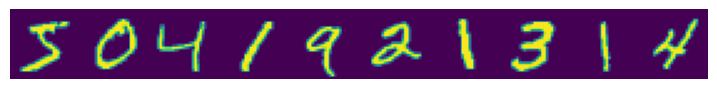

In [51]:
plt.figure(figsize=(9,9))
plt.imshow(torch.concatenate([MNIST_train[i][0][0] for i in range(10)], axis = 1))
plt.axis(False);

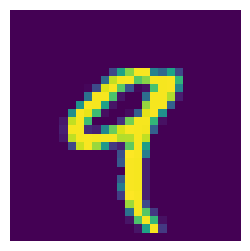

In [52]:
plt.figure(figsize=(3,3))
plt.imshow(MNIST_train[id1][0][0])
plt.imsave("original.jpeg", MNIST_train[1][0][0])
plt.axis(False);

In [56]:
# The dataset is as explained on above. The inputs are the pic_id concatenated with the pixel location, and the output is the pixel value.
class Datagen(torch.utils.data.IterableDataset):
	def __init__(self):
		super(Datagen).__init__()
		self.pics = (MNIST_train[id1][0][0],MNIST_train[id2][0][0])

		# init everything here

	def __iter__(self):
		return self

	def __next__(self):
		# this is called from pytorch once for every sample
		# do data preproc, augmentation etc. either here or in init
		pic_id = torch.randint(0,2,size=(1,))
		loc = torch.randint(0,28, size=(1,)),torch.randint(0,28, size=(1,))
		input = torch.stack((pic_id,loc[0]/27,loc[1]/27)).squeeze()
		value = self.pics[pic_id][loc[0],loc[1]]
		return (input,value)

In [54]:
gen = Datagen()
dl = DataLoader(gen,batch_size=batch_size)

In [55]:
def get_batch():
    global dl
    X,Y = next(iter(dl))
    X, Y = X.to(device), Y.to(device)
    return X,Y

In [61]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Simple MLP  with MSE Loss. The first linear layer will take the output of the position encoding.
        self.lin1 = nn.Linear(256*2,256)
        self.norm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.Sigmoid()
        self.lin2 = nn.Linear(256,128)
        self.norm2 = nn.BatchNorm1d(32)
        self.relu2 = nn.Sigmoid()
        self.lin3 = nn.Linear(128,32)
        self.norm3 = nn.BatchNorm1d(16)
        self.relu3 = nn.Sigmoid()
        self.lin4= nn.Linear(32,1)
        self.norm4 = nn.BatchNorm1d(8)
        self.relu4 = nn.Sigmoid()
        self.lin5= nn.Linear(8,1)
        self.relu5 = nn.ReLU()
        self.B = torch.randn(3,256)*0.2
    
    # We add a pos_encoding on the inputs... this will make the NN learn higher frequencies easier
    def pos_encod(self,X):
        x = X@self.B
        x = 2 * torch.pi * x
        x = torch.cat([torch.sin(x), torch.cos(x)], dim=1)
        return x

    def forward(self,x, target = None):
        
        x = self.pos_encod(x)
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin4(x)
        x = self.relu4(x)
        
        if target != None:
            loss = nn.MSELoss()(x,target)
            return x,loss
        else:
            return x

In [62]:
M = Model()
M.to(device=device)

Model(
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): Sigmoid()
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): Sigmoid()
  (lin3): Linear(in_features=128, out_features=32, bias=True)
  (norm3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): Sigmoid()
  (lin4): Linear(in_features=32, out_features=1, bias=True)
  (norm4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): Sigmoid()
  (lin5): Linear(in_features=8, out_features=1, bias=True)
  (relu5): ReLU()
)

In [63]:
@torch.no_grad()
def estimate_loss():
    out = {}
    M.eval()
    for split in ['train']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch()
            logits, loss = M(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    M.train()
    return out

In [64]:
iter_n = 0 
max_iter = 50*1000
optimizer = torch.optim.AdamW(M.parameters(), lr=1e-3)
while True:
    if iter_n % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_n}: train loss {losses['train']:.4f}")

    X,Y = get_batch()
    pred,loss = M(X, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    iter_n += 1
    if iter_n > max_iter:
        break

step 0: train loss 0.1813
step 10000: train loss 0.0271
step 20000: train loss 0.0205
step 30000: train loss 0.0103
step 40000: train loss 0.0053
step 50000: train loss 0.0078


In [47]:
import ipywidgets as wg


@wg.interact(h = wg.FloatSlider(min = 0, max = 2, step = 0.001, value=1, description = "number"))
def plot(h):
    
    size = 512
    x = torch.arange(0, size)  # Numbers from 0 to 28
    y = torch.arange(0, size)

    # Create a meshgrid of the tensors
    X, Y = torch.meshgrid(x, y)

    result = torch.stack((torch.ones_like(X.reshape(-1))*h,X.reshape(-1), Y.reshape(-1)), dim=1)
    result[:,-2:] /= (size-1)
    Y = M(result.to(device))
    plt.imshow(Y.view(size,size).cpu().detach().numpy())
    plt.imsave("upsample.jpeg",Y.view(size,size).cpu().detach().numpy())

    plt.show()

interactive(children=(FloatSlider(value=1.0, description='number', max=2.0, step=0.001), Output()), _dom_class…

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Create a white image
image = np.ones((100, 100, 3))  # RGB image

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the initial white image
im = ax.imshow(image)

# Create a slider widget
slider = widgets.FloatSlider(
    value=1.0,  # Initial value
    min=0.0,    # Minimum value
    max=1.0,    # Maximum value
    step=0.1,   # Increment step size
    description='Color:',   # Description label
    orientation='horizontal' # Slider orientation
)

# Define a function to update the image color when the slider changes
def update_image_color(change):
    color_value = change['new']
    updated_image = image * color_value  # Multiply each channel by the color value
    im.set_data(updated_image)  # Update the image data
    im.set_clim(vmin=0, vmax=1)  # Set the color limits
    plt.draw()  # Redraw the plot

# Register the function to be called when the slider value changes
slider.observe(update_image_color, 'value')

# Display the slider widget
display(slider)


ModuleNotFoundError: No module named 'ipywidgets'

In [42]:
import ipywidgets as widgets
import torch

# Create a tensor with an initial value
tensor = torch.tensor(0.0)

# Create a slider widget
slider = widgets.FloatSlider(
    value=0.0,  # Initial value
    min=0.0,    # Minimum value
    max=1.0,    # Maximum value
    step=0.1,   # Increment step size
    description=':',  # Description label
    orientation='horizontal'     # Slider orientation
)

# Define a function to update the tensor value when the slider changes
def update_tensor_value(change):
    tensor[0] = change['new']

# Register the function to be called when the slider value changes
slider.observe(update_tensor_value, 'value')

# Display the slider widget
display(slider)

FloatSlider(value=0.0, description=':', max=1.0)

In [40]:
slider

FloatSlider(value=1.0, max=1.0, step=0.01)

In [44]:
x = torch.linspace(0,1,1000)
y = x 

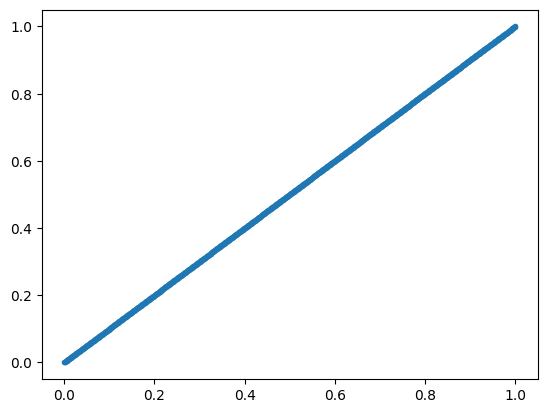

In [45]:
plt.plot(x,y, ".")